# Dynamic Linear Models and Kalman Filter
### Luca Laringe

In this notebook I will show some examples of how to apply Kalman Filter to dynamic linear models (a subclass of state-space models) in R using the "dlm" package. The notation is based on Petris et al. "Dynamic Linear models with R" (2007).

## Introduction

State-space models consider a time series as the output of a dynamic system perturbed by random disturbances. As we shall see, they allow a natural interpretation of a time series as the result of several components, such as trend, seasonal or
regressive components. At the same time, they have an elegant and powerful probabilistic structure, offering a flexible framework for a very wide range of applications. Computations can be implemented by recursive algorithms. The problems of estimation and forecasting are solved by recursively computing the conditional distribution of the quantities of interest, given the available information. In this sense, they are quite naturally treated from a Bayesian approach. State-space models can be used for modeling univariate or multivariate time series, also in presence of non-stationarity, structural changes, irregular
patterns. State-space models include ARMA models as special case, but as we shall see, they can be applied to nonstationary time series without requiring a preliminary transformation of the data to get stationarity.

## Dynamic Linear Models

The first, important class of state-space models is given by Gaussian linear state-space models, also called dynamic linear models (DLM). These models are specified by means of two equations:

The state equation, which describes the state vector $\theta_t$ (rx1), which is a Markov Chain:

$\theta_t = G_t \theta_{t-1} + w_t, w_t \sim \mathcal{N_r}(0,W_t)$

The observation equation, which assumes th observation vector $Y_t$ (nx1) is a function of the state vector plus a random disturbance:

$Y_t = F_t \theta_t + v_t, v_t \sim \mathcal{N_n}(0,V_t)$

The random disturbances, ($v_T$) and ($w_T$), are two independent white noise sequences. Since the Kalman filter is a recursive algorithm, the first step must be usually specified. In particular, it is also assumed:

$\theta_0 \sim \mathcal{N_r}(m_0,C_0)$

for some non-random vector $m_0$ and matrix $C_0$, and it is independent on ($v_T$) and ($w_T$).

## Kalman Filter

Let us know report the Kalman filter recursive formulas for the general dynamic linear model described earlier.

If $\theta_{t-1} \mid \mathcal{D}_{t-1} \sim \mathcal{N_r}(m_{t-1},C_{t-1})$,  where $t \geq 1$, then:

(a) the one-step-ahead state predictive density of $\theta_t \mid \mathcal{D}_{t-1}$ is Gaussian, with parameters:

$a_t = \mathbb{E}[\theta_t \mid \mathcal{D}_{t-1}] = G_t m_{t-1}$

$R_t = \mathbb{V}[\theta_t \mid \mathcal{D}_{t-1}] = G_t C_{t-1} G_t^\intercal + W_t$

(b) the one-step-ahead predictive density of $Y_t \mid \mathcal{D}_{t-1}$ is Gaussian, with parameters:

$f_t = \mathbb{E}[\theta_t \mid \mathcal{D}_{t-1}] = F_t a_{t}$

$Q_t = \mathbb{V}[\theta_t \mid \mathcal{D}_{t-1}] = F_t R_{t} F_t^\intercal + V_t$

(c) the filtering density of $\theta_t \mid \mathcal{D}_{t}$ is Gaussian, with parameters:

$m_t = \mathbb{E}[\theta_t \mid \mathcal{D}_{t}] = a_t + R_t F_{t}^\intercal Q_t^{-1} (Y_t - f_t)$

$C_t = \mathbb{V}[\theta_t \mid \mathcal{D}_{t}] = R_{t} - R_t F_{t}^\intercal Q_t^{-1} F_t R_t$

Note that the expression of $m_t$ has the intuitive estimation-correction form
”filter mean equal to the prediction mean at plus a correction depending on
how much the new observation differs from its prediction”. The weight of the
correction term is given by the gain matrix:

$ K_t = R_t F_{t}^\intercal Q_t^{-1}$

The evaluation of the posterior variances Ct (and consequently also of Rt and Qt) using the previous iterative updating formulae, as simple as it may appear, suffers from numerical instability that may lead to nonsymmetric and even negative definite calculated variance matrices. Alternative, stabler, algorithms have been developed to overcome this issue. Apparently,
the most widely used, at least in the Statistics literature, is the square root filter, which provides formulae for the sequential update of a square root of Ct. References for the square root filter are Morf and Kailath (1975) and Anderson and Moore (1979, Ch. 6). A more robust algorithm is the one based on sequentially updating the singular value decomposition6 (SVD) of Ct. The details of the algorithm can be found in Oshman and Bar-Itzhack (1986) and Wang et al. (1992). The dlm package use this algorithm to update variance matrices.

#### Example: Linear Regression

Linear regression can be thought as a DLM. Moreover, in the DLM structure, it can be extended to have time-varying coefficients. Let us give the state and observation equations that describe this process. For simplicity, let us assume that the $\beta$ vector contains the constant as a first component and hence the $x_t$ vector contains 1 as first component.

$\beta_t = \beta_{t-1} + w_t, w_t \sim \mathcal{N_r}(0,W_t)$

$y_t = x_t'\beta_t + v_t, v_t \sim \mathcal{N_n}(0,V_t)$

We also assume our prior distribution on $\beta_0$ to be:

$\beta_0 \sim \mathcal{N_2}(b_0,C_0)$

Let us know see an application of this model for the dynamic estimation of Google's $\beta$.

In [1]:
# Loading useful libraries
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
library(tseries)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [3]:
library(dlm)


Attaching package: 'dlm'


The following object is masked from 'package:ggplot2':

    %+%




In [4]:
library(forecast)

In [5]:
library(quantmod)

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last


Loading required package: TTR

Version 0.4-0 included new data defaults. See ?getSymbols.



In [6]:
library(broom)

In [7]:
library(timetk)

In [8]:
# Set ggplot theme
th <- theme_minimal() + 
  theme(plot.title = element_text(size=12, face="bold"),
        axis.title.x = element_text(size=7),                
        axis.title.y = element_text(size=7),
        legend.text = element_text(size=5),
        legend.title = element_text(size=7),
        axis.text = element_text(size=9),
        strip.text = element_text(size=8, face = "italic"))

In [9]:
# Downloading data
y_raw <- getSymbols("GOOG",src="yahoo", auto.assign = FALSE)
x_raw <- getSymbols("^GSPC",src="yahoo", auto.assign = FALSE)

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.




In [10]:
# Focus on adjusted close price
y <- y_raw[,"GOOG.Adjusted"]
x <- x_raw[,"GSPC.Adjusted"]

In [11]:
# Modify time window
y <- window(y, start = "2010-01-01", end = "2020-07-01")
x <- window(x, start = "2010-01-01", end = "2020-07-01")

# interpolate na
y <- na.approx(y)
x <- na.approx(x)

In [12]:
# Monthly frequency (each price corresponds to the first observed each month)
x <- apply.monthly(x, first)
index(x) <- as.yearmon(index(x))
y <- apply.monthly(y, first)
index(y) <- as.yearmon(index(y))

[1] TRUE

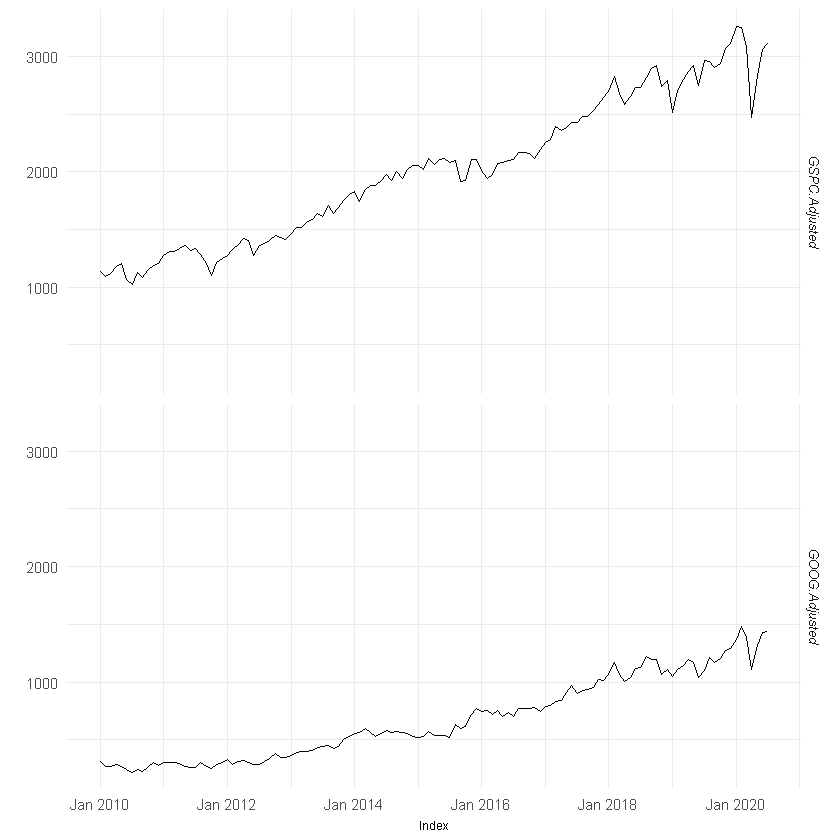

In [13]:
# Make sure series have same length and plot
length(x) == length(y)
autoplot(merge(x,y)) + th

In [14]:
# Log return series
x <- na.omit(diff(log(x)))
y <- na.omit(diff(log(y)))

In [15]:
# Check beta estimate for clasical regression
lin_reg <- lm(y ~ x)
tidy(lin_reg)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.003720893,0.004921827,0.7559983,4.510840e-01
x,1.046359624,0.105800235,9.8899556,2.339112e-17


According to the classical time-series regression, the beta of Google is estimated to be around 1.04. Let's now try to look at the beta estimate when we allow this parameter to vary through time.

In [16]:
# In order to define the model, we only need the regressor, the regressand is going to enter the model once we use a filter or a smoother
# We can use the estimates from the simple regression as initial guesses for the state parameters (alpha and beta)
# All the other parameters are going to be left as default
dlm_lin_reg <- dlmModReg(x, m0 = tidy(lin_reg)["estimate"][[1]])

# Create filter ans smoother objects
dlm_lin_reg_filt <- dlmFilter(y, dlm_lin_reg)
dlm_lin_reg_smooth <- dlmSmooth(dlm_lin_reg_filt)

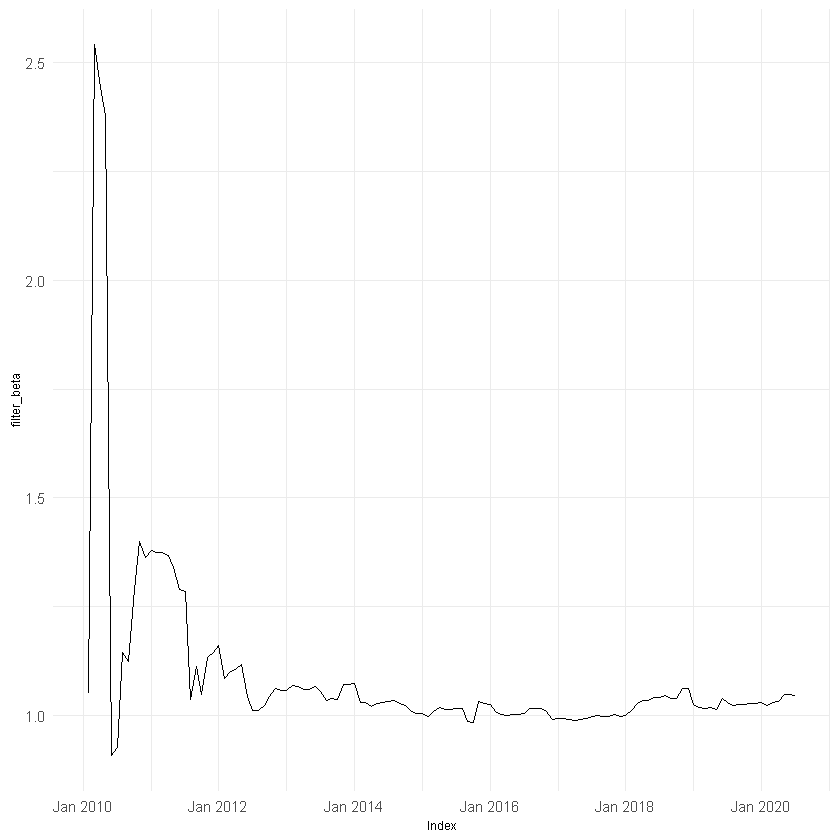

In [17]:
# Plot the filtered estimated of beta through time
t <- time(x)
filter_beta <- zoo(dlm_lin_reg_filt$m[-1,2])
time(filter_beta) <- t
smoother_beta <- zoo(dlm_lin_reg_smooth$s[-1,2])
time(smoother_beta) <- t

autoplot(filter_beta) + th

In [18]:
# As of sample ending's estimate of beta:
filter_beta[length(filter_beta)]

Jul 2020 
 1.04636 

As we can see the beta estimate is very close to the classic regression model's one. Moreover, we can see that Google's beta has been pretty constant over time. Note that the initial variance is due to the very diffuse prior we had for the state variable at time 0. Note that for this simple example we kept all the parameters to default. In general, the parameters of the model (for example the white noise process covariance matrix) can and should be estimated via maximum likelihood or bayesian methods. Let's try to estimate the parameters of the model by mle.

Recall that in the dynamic regression model we just specified, using the terminology of the last section, the unknown parameters are $W_t, V_t$, the variance matrices (scalars in the $V_t$ case) of the error terms. These were set to the default:

In [19]:
print(dlm_lin_reg$V)
print(dlm_lin_reg$W)

     [,1]
[1,]    1
     [,1] [,2]
[1,]    0    0
[2,]    0    0


As we can see, the default value for W was actually a null matrix. This implied alpha and beta costant through time because their innovation process does not have variance. If we really wanted time-varying parameters, we should have specified this matrix to be non null. On the other hand, the default value for V was 1, which is totally unrelated with our problem, so we need to change this too. How to choose the right parameters? A very convenient solution is given by mle estimation. We first have to define the matrices as functions of some parameters, then the dlm library will automatically maximize the log likelohood of the model. The dlmModReg function assumes uncorrelated innovations for the state variables, alpha and beta, hence the matrix W is diagonal and we only need to estimate 3 parameters.

In [20]:
# define a parmeter vector (you can also define it directly in the dlmMLE function)
parm <- c(0,0,0)  # V, W_1_1, W_2_2

# define a dlm as a function of the params (we taxe e^param so we impose variances to be positive)
build <- function(parm) {
dlmModReg(x, m0 = tidy(lin_reg)["estimate"][[1]], dV = exp(parm[1]),
          dW = c(exp(parm[2]),exp(parm[3])))
}

# MLE
dlm_lin_reg_mle <- dlmMLE(y, parm, build)

Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


In [21]:
dlm_lin_reg_mle

$par
[1]  -5.822105 -26.238782 -19.834664

$value
[1] -281.0994

$counts
function gradient 
      37       37 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

Convergence equal to zero means that convergence to a log-likelihood maximum has been achieved. We can now buil the actual model and visualized filtered and smoothed estimates for the beta, out variable of intrest.

In [22]:
# Build the model using the mle
dlm_lin_reg <- build(dlm_lin_reg_mle$par)

In [23]:
# Visualize estimated variance matrices:
print(dlm_lin_reg$V)
print(dlm_lin_reg$W)

            [,1]
[1,] 0.002961365
             [,1]         [,2]
[1,] 4.023851e-12 0.000000e+00
[2,] 0.000000e+00 2.431727e-09


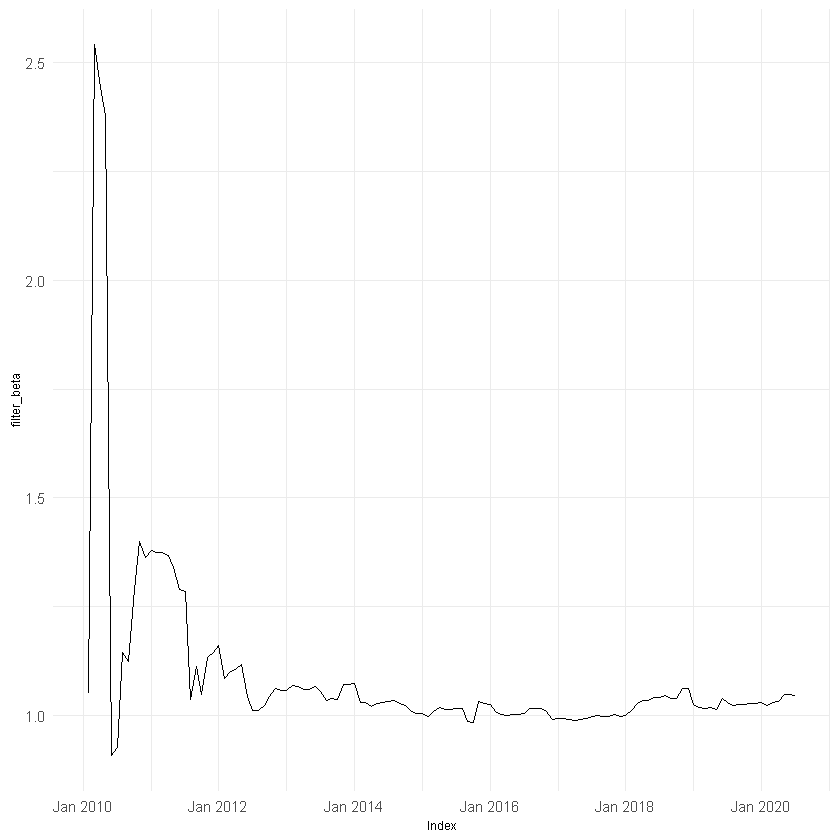

In [24]:
# Bild a filter and visualize it
# Create filter ans smoother objects
dlm_lin_reg_filt <- dlmFilter(y, dlm_lin_reg)
dlm_lin_reg_smooth <- dlmSmooth(dlm_lin_reg_filt)
# Plot the filtered estimated of beta through time
t <- time(x)
filter_beta <- zoo(dlm_lin_reg_filt$m[-1,2])
time(filter_beta) <- t
smoother_beta <- zoo(dlm_lin_reg_smooth$s[-1,2])
time(smoother_beta) <- t

autoplot(filter_beta) + th

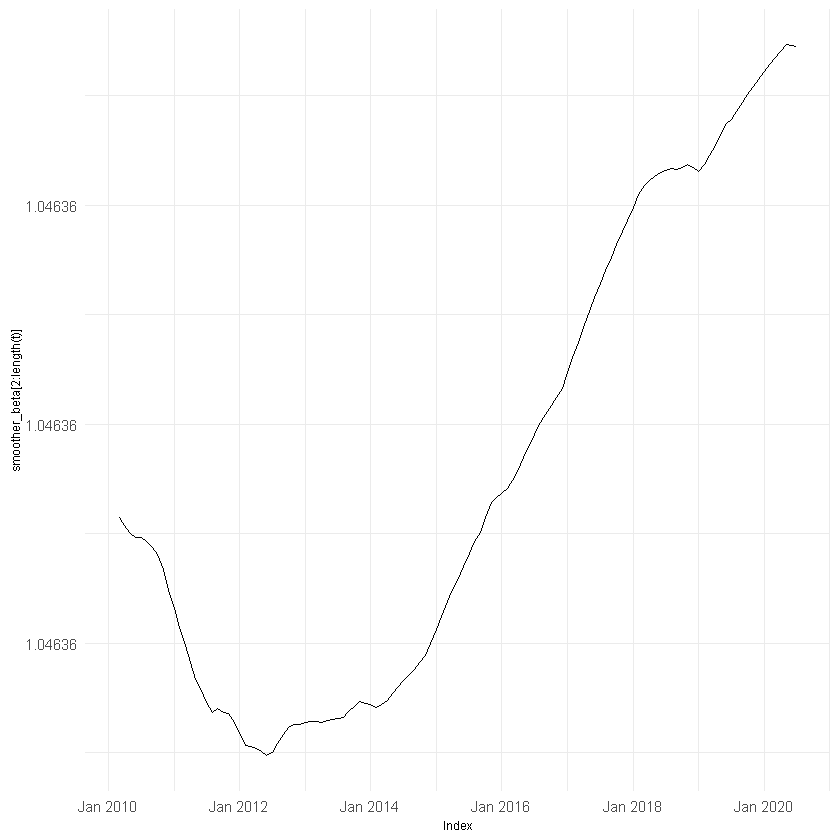

In [25]:
autoplot(smoother_beta[2:length(t)]) + th

As we can see, the smoother chart indicates that Google's beta has slighlty increased over the last 10 years. Let us look at our final beta estimate:

In [26]:
filter_beta[length(t)]

Jul 2020 
 1.04636 

The beta estimate is the same as before. Meaning that the beta has really been stable over time, as the simple regression ponts us in the same direction of the dynamic regression.

## Trend models

DLMs have the very nice property, which allows us to split a time series into several components and model each of these components as a separate DLM. For example, instead of modelling the differenced series separately from the level series, one could specify a dlm that descibes the trend, one that describes the deviations from the trend (supposedly stationary) and add them up together to forecast directly the series of intrest. Let us look at how we could model a trend component. To model a trend component, one could draw from many models, one example of such models is the random walk plus noise, or local level model. Note that in such a model, if we set the noise variance to 0 the whole exercise we just described would just amount to model the differenced series using a dlm, as the forecast for the trend componend would simply be the value of the series at time t.

### Random Walk plus Noise
The random walk plus noise, or local level model, is defined by the following two equations. 

$\mu_t = \mu_{t-1} + w_t, w_t \sim \mathcal{N}(0,W)$

$Y_t = \mu_t + v_t, v_t \sim \mathcal{N}(0,V)$

As noted there, the behavior of the process (Yt) is greatly influenced by the signal-to-noise ratio r = W/V , the ratio between the two error variances. This model is very helpful wher no clear upward or downward trend is detected. Let's look at the Nile river flows as an example.

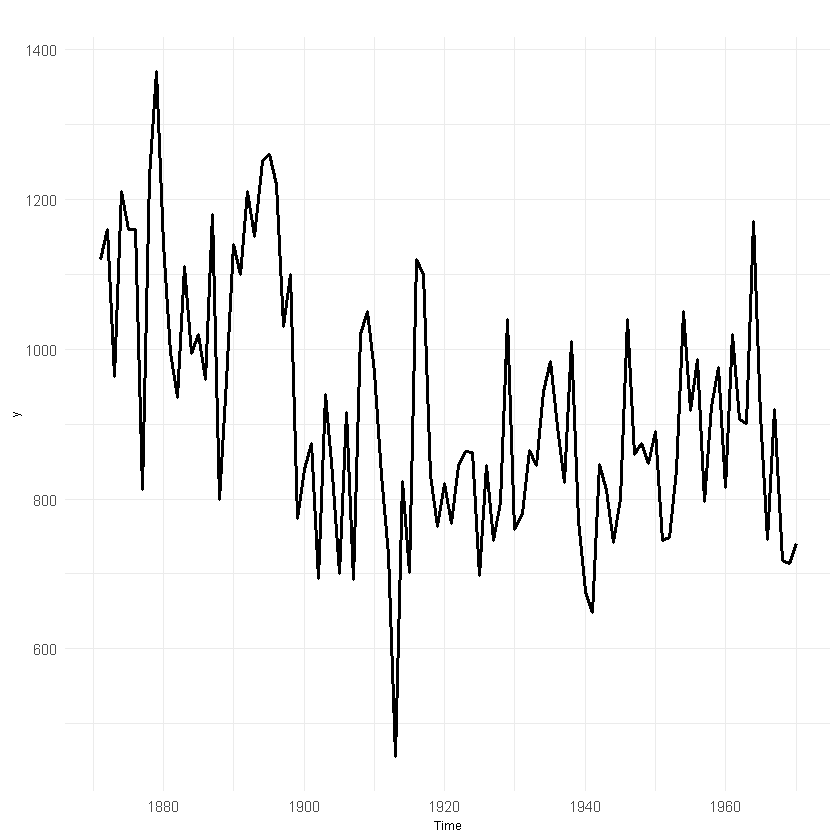

In [27]:
# Let's look at the Nile river flows
y <- Nile
autoplot(y, size = 1) + th

The series doesn't show any trends and seems to fluctuate around some local level. The random walk plus noise is an appropriate model to describe this series.

In [28]:
# define a parmeter vector (you can also define it directly in the dlmMLE function)
parm <- c(0,0)  # V, W

# define a dlm as a function of the params (we taxe e^param so we impose variances to be positive)
# We set the initial estimate od the local level to be the average of the series
build <- function(parm) {
dlmModPoly(order = 1, m0 = mean(y), dV = exp(parm[1]),
          dW = exp(parm[2]))
}

# MLE
dlm_lin_reg_mle <- dlmMLE(y, parm, build)

In [29]:
dlm_lin_reg_mle

$par
[1] 9.622381 7.292259

$value
[1] 549.6319

$counts
function gradient 
      33       33 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

The log-likelihood maximization has worked. We can go on and plot the filtered series, which represents the local leves around which the series fluctuates.

In [30]:
loc_level <- build(dlm_lin_reg_mle$par)

# Bild a filter and visualize it
# Create filter ans smoother objects
loc_level_filt <- dlmFilter(y, loc_level)
loc_level_smooth <- dlmSmooth(loc_level_filt)
# Plot the filtered estimated of beta through time
t <- time(y)
filter <- zoo(loc_level_filt$m[-1])
time(filter) <- t
smoother <- zoo(loc_level_smooth$s[-1])

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



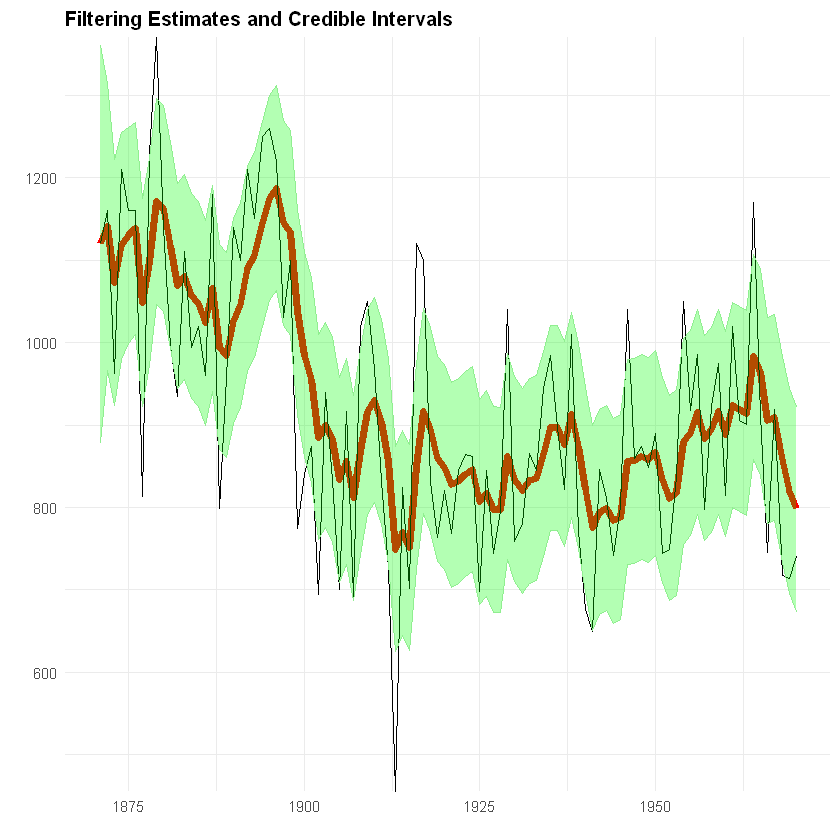

In [31]:
# Plot the series, the filtered local level with 95% confidence bounds

# Reconstruct filtering variances from SV Decomposition
var_filter <- ts(with(loc_level_filt, unlist(dlmSvd2var(U.C, D.C))), start = start(filter))
sd_filter <- sqrt(var_filter)

#Confidence interval under normality of errors
upper <- filter+qnorm(0.975)*sd_filter[-1]
lower <- filter-qnorm(0.975)*sd_filter[-1]

time = time(filter)
data <- tibble(time, y, filter, upper, lower)

ggplot(data, aes(x = time)) +
    th +
    ggtitle("Filtering Estimates and Credible Intervals") +
    scale_y_continuous(expand = c(0,0)) +
    xlab("") + ylab("") +
    geom_line(aes(y = filter),col = c("red"), size = 2) +
    geom_line(aes(y = y),col = c("black")) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha=0.3, linetype=1, colour="lightgreen", size=0.1,fill="green")

The series seems to show a breakpoint just before 1900. As a matter of fact, the annual flows drop in 1898 because the first Ashwan dam was built. Let us confirm this historical fact by testing for structural change.

Loading required package: sandwich


Attaching package: 'strucchange'


The following object is masked from 'package:stringr':

    boundary





	 Optimal (m+1)-segment partition: 

Call:
breakpoints.formula(formula = y ~ 1)

Breakpoints at observation number:
                      
m = 1      28         
m = 2      28       83
m = 3      28    68 83
m = 4      28 45 68 83
m = 5   15 30 45 68 83

Corresponding to breakdates:
                                
m = 1        1898               
m = 2        1898           1953
m = 3        1898      1938 1953
m = 4        1898 1915 1938 1953
m = 5   1885 1900 1915 1938 1953

Fit:
                                                   
m   0       1       2       3       4       5      
RSS 2835157 1597457 1552924 1538097 1507888 1659994
BIC    1318    1270    1276    1285    1292    1311

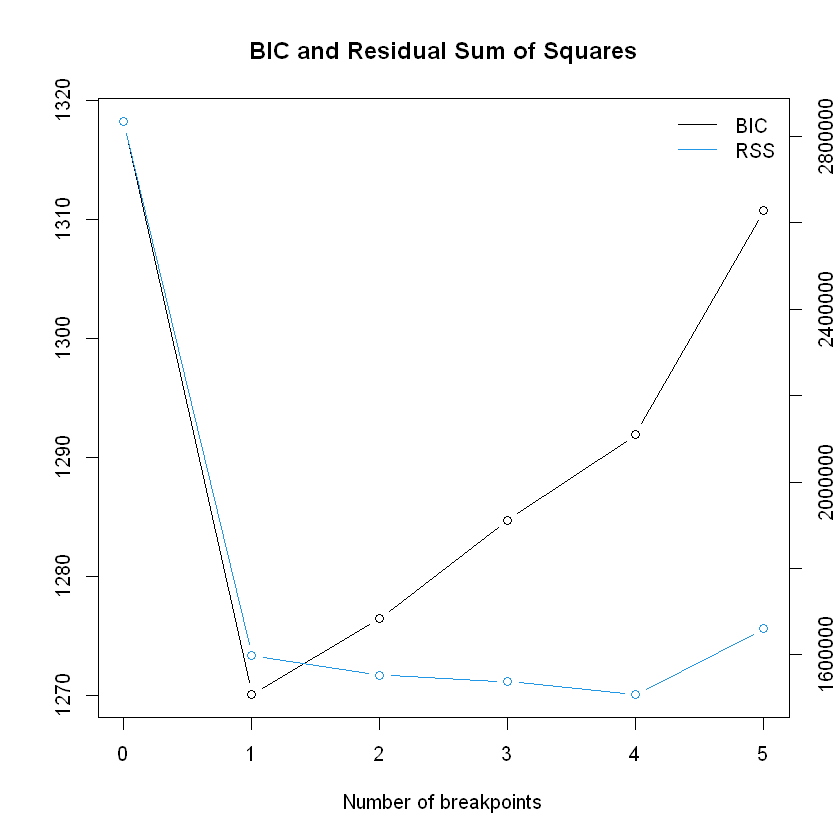

In [32]:
# Nile data with one breakpoint: the annual flows drop in 1898
library(strucchange)
bp.nile <- breakpoints(y ~ 1)
summary(bp.nile)
plot(bp.nile)

As we can see, the lowes BIC happens when 1 breakpoint is considered, and that breakpoint actually corresponds to 1898, in line with our historical knowledge. How can we incorporate this information to improve the local level model? We should allow a structural break during 1898, so that the filter level can more quickly adapt to the abrupt change. This is usually done by modifying the W parameter and making it become time dependent, in particular we will set it to a cerain value, $W_0$ for all periods besided 1898, where it is gonna have a value of $W_0*k$, where k is a multiplier greater than 1. We will estimate $W_0$ and $k$ by maximum likelihood.

In [33]:
# define a dlm as a function of the params (we taxe e^param so we impose variances to be positive)
# We set the initial estimate od the local level to be the average of the series
build_sb <- function(parm) {
    m <- dlmModPoly(order = 1, m0 = mean(y), dV = exp(parm[1]))
    m$JW <- matrix(1) # Makes W be time dependent
    m$X <- matrix(exp(parm[2]), ncol=1, nrow=length(y))
    j <- which(time(Nile) == 1898)
    m$X[j,1] <- m$X[j,1] * (1 + exp(parm[3]))
    return(m)
}

dlm_lin_reg_sb_mle <- dlmMLE(y, c(0,0,0), build_sb)
loc_level_sb <- build_sb(dlm_lin_reg_sb_mle$par)

In [34]:
# Bild a filter and visualize it
# Create filter ans smoother objects
loc_level_filt <- dlmFilter(y, loc_level_sb)
loc_level_smooth <- dlmSmooth(loc_level_filt)
# Plot the filtered estimated of beta through time
t <- time(y)
filter <- zoo(loc_level_filt$m[-1])
time(filter) <- t
smoother <- zoo(loc_level_smooth$s[-1])

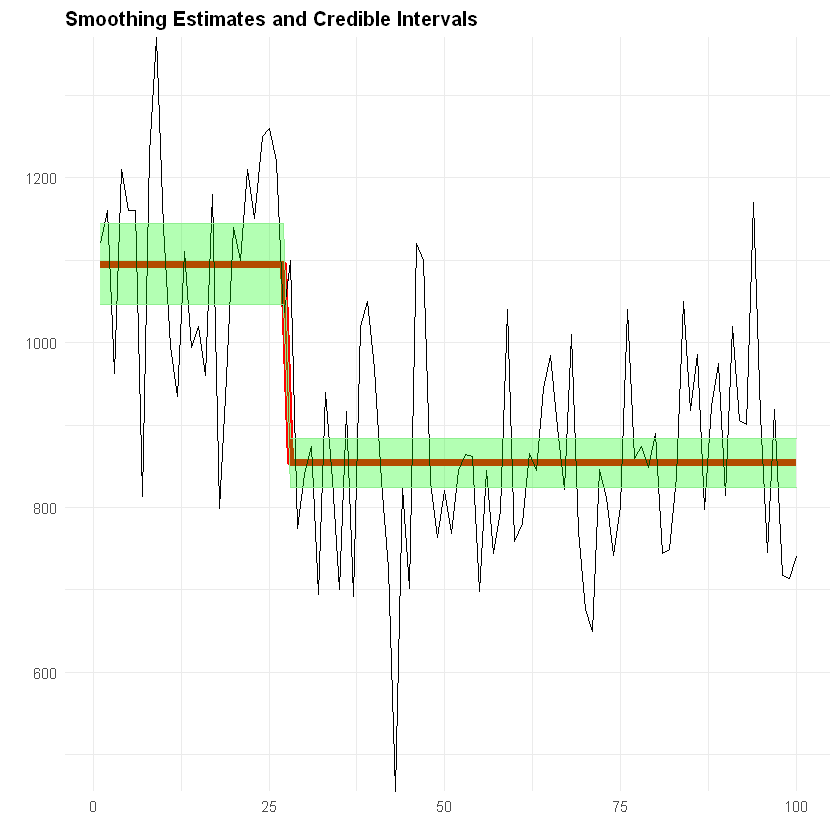

In [35]:
# Plot the series, the smoothed local level with 95% confidence bounds

# Reconstruct smoothing variances from SV Decomposition
var_smoother <- ts(with(loc_level_smooth, unlist(dlmSvd2var(U.S, D.S))), start = start(smoother))
sd_smoother <- sqrt(var_smoother)

#Confidence interval under normality of errors
upper <- smoother+qnorm(0.975)*sd_smoother[-1]
lower <- smoother-qnorm(0.975)*sd_smoother[-1]

time <- time(smoother)
data <- tibble(time, y, filter, smoother, upper, lower)

ggplot(data, aes(x = time)) +
    th +
    ggtitle("Smoothing Estimates and Credible Intervals") +
    scale_y_continuous(expand = c(0,0)) +
    xlab("") + ylab("") +
    geom_line(aes(y = smoother),col = c("red"), size = 2) +
    geom_line(aes(y = y),col = c("black")) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha=0.3, linetype=1, colour="lightgreen", size=0.1,fill="green")

### Linear Growth Model

The local level model is a special case of as class of models defined al polynomial of order n. For instance, the random walk plus noise is a polynomial model of order 1. In general, polynomial models of order n have the following forecast function:

$ f_t(k) = E(Y_{t+k} \mid \mathcal{D}_t) = a_{t,0} + a_{t,1}k + · · · + a_{t,n-1}k^{n−1}, k \geq 0$ 

where $a_{t,0}, ..., a_{t,n-1}$ are linear functions of $ m_t = E(Y_{t} \mid \mathcal{D}_t)$ and are independent of k. Thus, the forecast function is a polynomial of order (n − 1) in k. In the random walk plus noise, the forecast function was simply:

$f_t(k) = E(Y_{t+k} \mid \mathcal{D}_t) = a_{t,0} = m_t$

A polynomial model of order 2 is defined linear growth model, or local linear trend model. The forecast function for a linear growth model has the following form:

$f_t(k) = E(Y_{t+k} \mid \mathcal{D}_t) = a_{t,0} + a_{t,0} k$

As we can see, this forecast function extrapolates and projects into the future a linear trend of the data. The local linear trend model is defined by the following equations:

$Y_t = \mu_t + v_t, v_t \sim \mathcal{N}(0,V)$

$\mu_t = \mu_{t-1} + \beta_{t-1} + w_{1,t}, w_{1,t} \sim \mathcal{N}(0,\sigma^2_{w_1})$

$\beta_t = \beta_{t-1} + w_{2,t}, w_{2,t} \sim \mathcal{N}(0,\sigma^2_{w_2})$

With uncorrelated errors. Let's try to fit this model to data that show a linear trend.


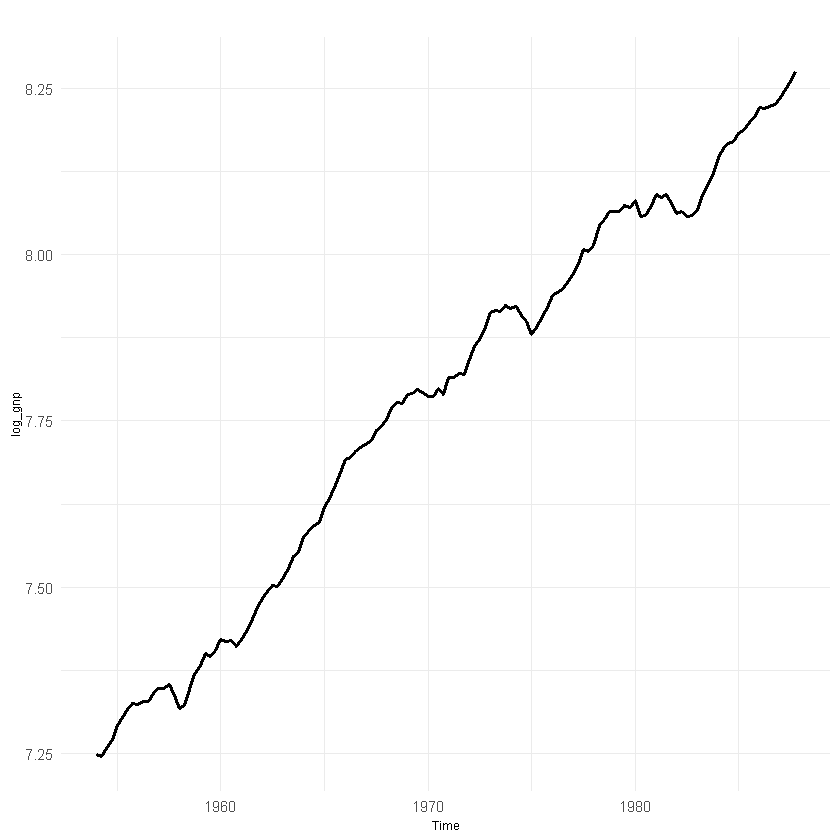

In [36]:
data("USeconomic")
log_gnp <- USeconomic[,"log(GNP)"]
autoplot(log_gnp, size = 1) + th

The log og the GNP seems a very good time-series to fit a linear growth model as the trend component. 

In [37]:
# Model builder
build <- function(parm){
    dlmModPoly(order = 2, dV = exp(parm[1]), dW = c(exp(parm[2]), exp(parm[3])))   
}

ll_mle <- dlmMLE(log_gnp, c(0,0,0), build)
ll <- build(ll_mle$par)

Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


In [38]:
# Filter estimates
ll_filt <- dlmFilter(log_gnp, ll) 

# Forecast
ll_forecast <- dlmForecast(ll_filt, 20)

Warning message:
"Removed 136 row(s) containing missing values (geom_path)."
Warning message:
"Removed 20 row(s) containing missing values (geom_path)."


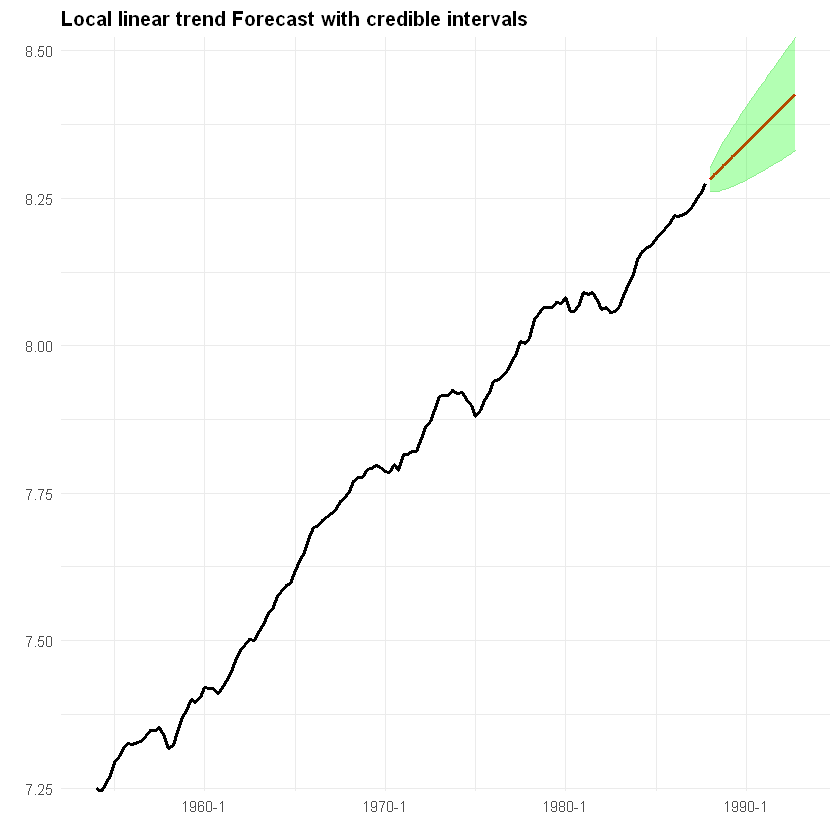

In [39]:
forecast <- ll_forecast$f
var_forecast <- unlist(ll_forecast$Q)
sd_forecast <- sqrt(var_forecast)

#Confidence interval under normality of errors
upper <- forecast+qnorm(0.975)*sd_forecast
lower <- forecast-qnorm(0.975)*sd_forecast

data <- ts.union(log_gnp, forecast, upper, lower)
data <- tk_tbl(data, rename_index = "time")

ggplot(data, aes(x = time)) +
    th +
    ggtitle("Local linear trend Forecast with credible intervals") +
    scale_y_continuous(expand = c(0,0)) +
    xlab("") + ylab("") +
    geom_line(aes(y = forecast),col = c("red"), size = 1) +
    geom_line(aes(y = log_gnp),col = c("black"), size = 1) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha=0.3, linetype=1, colour="lightgreen", size=0.1,fill="green")

## Seasonality models

Once we understood how to model trend using DLMs, it is time to learn how to model seasonalities. One of the coolest things about DLMs is the fact that you can specify different DLMs to describe different components and then simply combine them together to get a compound model. This is done seamlessly in dlm with the use of the + operator.
Suppose that we also want to model the seasonalities of the US log GNP series. This can be done in a varieties of ways but I will just focus on the main 2 ways. I will model the detrended log gnp series as an example, then I will sum up the two models.

In [40]:
# Get detrended series
log_gnp_detrended <- log_gnp - ll_filt$m[,1]

[1] -6.447495e-11


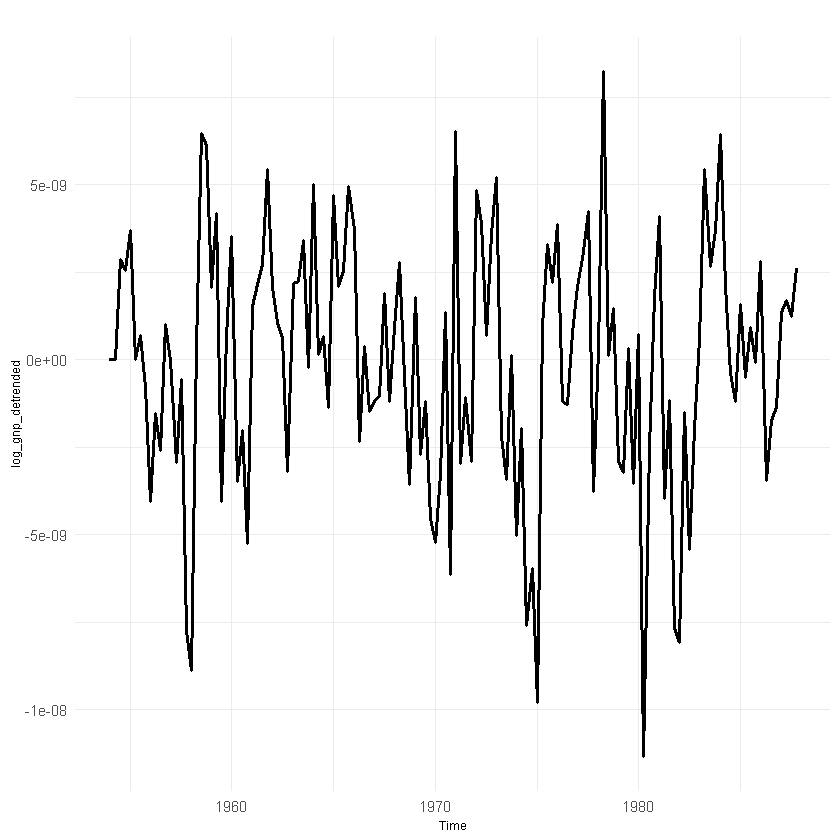

In [41]:
print(mean(log_gnp_detrended))
autoplot(log_gnp_detrended, size = 1) + th

### Seasonal Factor Models

This model takes data with a certain frequency, say 1/n, and estimates the n deviations from the mean that repeat every cycle of n observations. In our example, we have quarterly data (frequency = 1/4), so the seasonal factor model will estimate 4 factors, each related to a specific quarter, that will add up to the mean (in this case 0, since the series is detrended). In the static seasonal model, wt is degenerate on a vector of zeros (i.e., Wt = 0) More generally, the seasonal effects might change in time, so that Wt is nonzero and has to be carefully specified.

In [42]:
# Model builder
build <- function(parm){
    dlmModSeas(frequency = 4, dV = exp(parm[1]), dW = rep(0,3))   
}

seas_mle <- dlmMLE(log_gnp_detrended, c(0,0,0), build)
seas <- build(seas_mle$par)

Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


In [43]:
seas_fil <- dlmFilter(log_gnp_detrended, seas)
one_step_ahead_forecasts <- seas_fil$f

Warning message in dlmFilter(log_gnp_detrended, seas):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



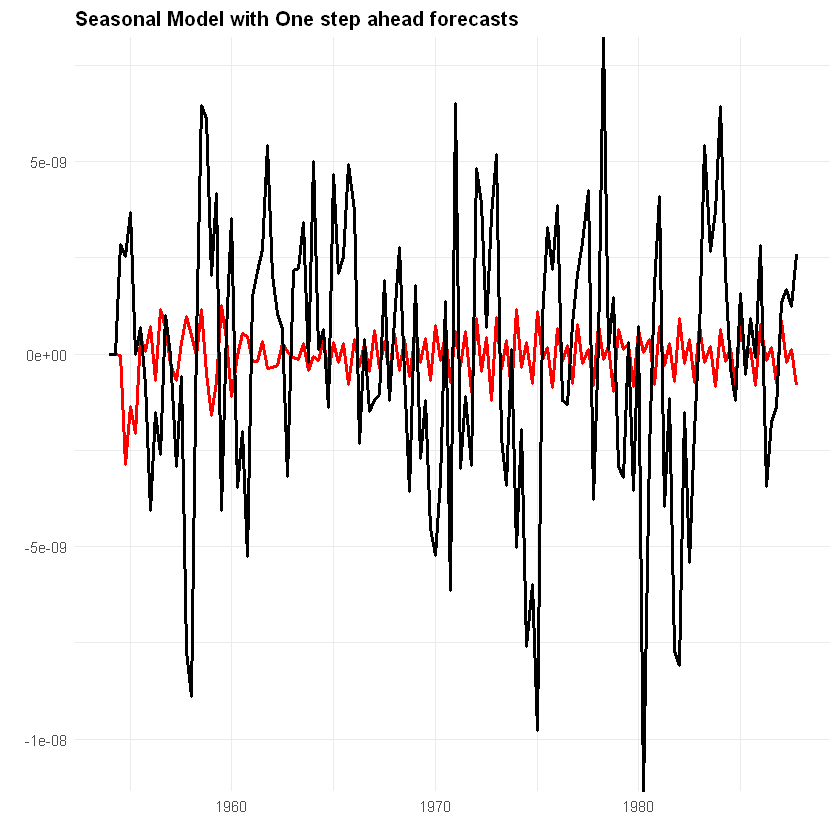

In [44]:
time = time(log_gnp_detrended)
data <- tibble(time, log_gnp_detrended, one_step_ahead_forecasts)

ggplot(data, aes(x = time)) +
    th +
    ggtitle("Seasonal Model with One step ahead forecasts") +
    scale_y_continuous(expand = c(0,0)) +
    xlab("") + ylab("") +
    geom_line(aes(y = one_step_ahead_forecasts),col = c("red"), size = 1) +
    geom_line(aes(y = log_gnp_detrended),col = c("black"), size = 1)

### Fourier Seasonality Model

These kind of models are especially used when the frequency of the data is wery low, as instead of estimating n seasonal factors, using cyclical functions leads to a more parsimonious representation.

In [45]:
# Model builder
# s = freq, q = number of periodic functions
build <- function(parm){
    dlmModTrig(s = 4, q = 2, dV = exp(parm[1]))   
}

seas_fourier_mle <- dlmMLE(log_gnp_detrended, c(0,0,0), build)
seas_fourier <- build(seas_mle$par)

Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


Warning message in dlmFilter(log_gnp_detrended, seas_fourier):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


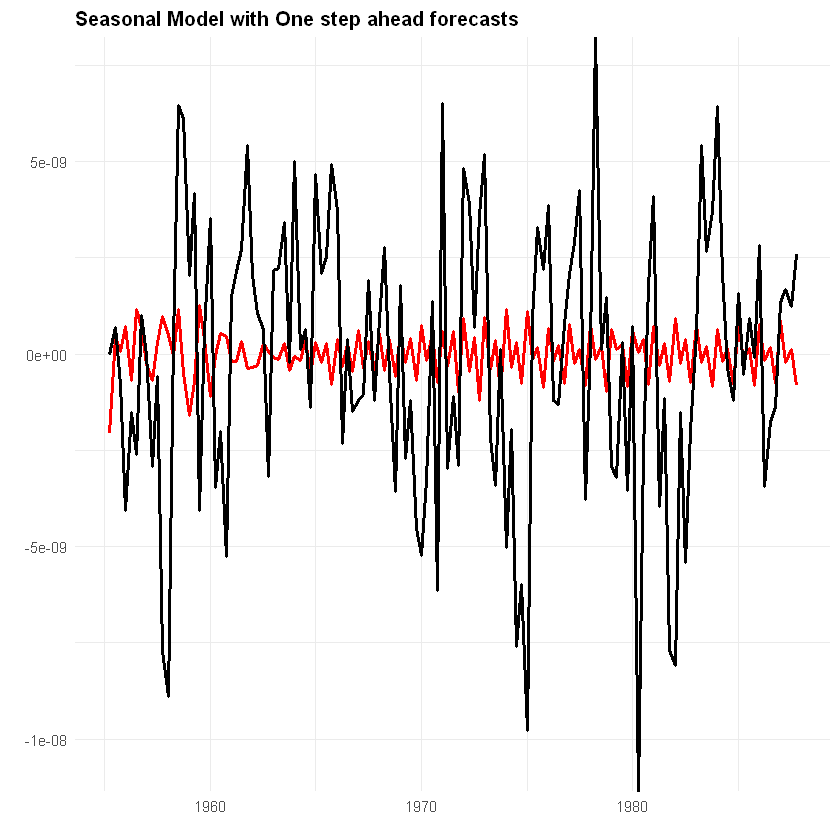

In [46]:
seas_fourier_fil <- dlmFilter(log_gnp_detrended, seas_fourier)
one_step_ahead_forecasts <- seas_fourier_fil$f

time = time(log_gnp_detrended)
data <- tibble(time, log_gnp_detrended, one_step_ahead_forecasts)  %>% 
    filter(time > 1955)

ggplot(data, aes(x = time)) +
    th +
    ggtitle("Seasonal Model with One step ahead forecasts") +
    scale_y_continuous(expand = c(0,0)) +
    xlab("") + ylab("") +
    geom_line(aes(y = one_step_ahead_forecasts),col = c("red"), size = 1) +
    geom_line(aes(y = log_gnp_detrended),col = c("black"), size = 1)

As we said before, the dlm package seamlessy allows us to sum two models, for example, let's add the linear trend model to the Fourier seasonality model and plot forecasts with credible intervals. In order to do so, we are going to assume the parameters we estimated prevously.

In [47]:
# New model as a sum of models

build <- function(parm){
    m1 <- dlmModPoly(order = 2, dV = exp(parm[1]), dW = c(exp(parm[2]), exp(parm[3])))
    m2 <- dlmModSeas(frequency = 4, dV = exp(seas_mle$par[1]), dW = rep(0,3))
    return(m1 + m2)
}

ll_seas <- build(ll_mle$par)

In [48]:
# Filter estimates
ll_seas_filt <- dlmFilter(log_gnp, ll_seas) 

# Forecast
ll_seas_forecast <- dlmForecast(ll_seas_filt, 20)

Warning message:
"Removed 136 row(s) containing missing values (geom_path)."
Warning message:
"Removed 20 row(s) containing missing values (geom_path)."


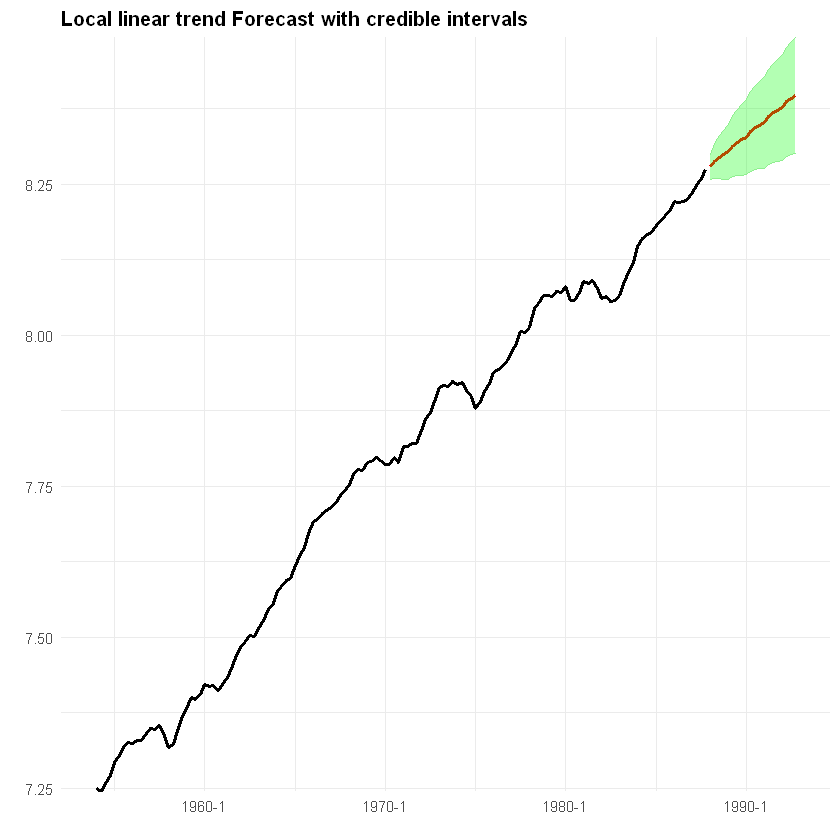

In [49]:
forecast <- ll_seas_forecast$f
var_forecast <- unlist(ll_seas_forecast$Q)
sd_forecast <- sqrt(var_forecast)

#Confidence interval under normality of errors
upper <- forecast+qnorm(0.975)*sd_forecast
lower <- forecast-qnorm(0.975)*sd_forecast

data <- ts.union(log_gnp, forecast, upper, lower)
data <- tk_tbl(data, rename_index = "time")

ggplot(data, aes(x = time)) +
    th +
    ggtitle("Local linear trend Forecast with credible intervals") +
    scale_y_continuous(expand = c(0,0)) +
    xlab("") + ylab("") +
    geom_line(aes(y = forecast),col = c("red"), size = 1) +
    geom_line(aes(y = log_gnp),col = c("black"), size = 1) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha=0.3, linetype=1, colour="lightgreen", size=0.1,fill="green")

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."


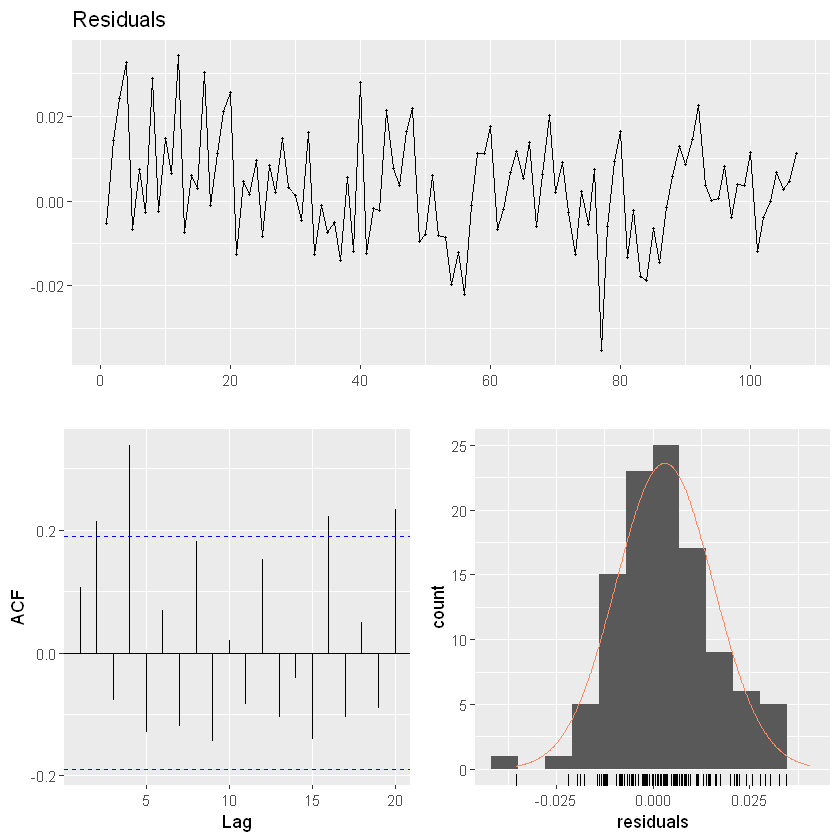

In [50]:
# Let's run diagnostic on the one-step ahead forecasts residuals for this model
e <- log_gnp - ll_seas_filt$f
checkresiduals(e[30:length(e)])